In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy

In [7]:
%%bash -e
if ! [[ -f ./linkern ]]; then
  wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
  echo 'c3650a59c8d57e0a00e81c1288b994a99c5aa03e5d96a314834c2d8f9505c724  co031219.tgz' | sha256sum -c
  tar xf co031219.tgz
  (cd concorde && CFLAGS='-Ofast -march=native -mtune=native -fPIC' ./configure --build=x86_64)
  (cd concorde/LINKERN && make -j && cp linkern ../../)
  rm -rf concorde co031219.tgz
fi

co031219.tgz: OK
creating cache ./config.cache
checking host system type... 
checking for prespecified compiler options... no
checking for gcc... gcc
checking whether the C compiler (gcc -Ofast -march=native -mtune=native -fPIC ) works... yes
checking whether the C compiler (gcc -Ofast -march=native -mtune=native -fPIC ) is a cross-compiler... no
checking whether we are using GNU C... yes
checking whether gcc accepts -g... yes
checking whether make sets ${MAKE}... yes
checking for ranlib... ranlib
checking for sh... /bin/sh
checking for file suffixes... o, a, 
checking for sqrt in -lm... yes
checking for -lnsl... no
checking for -lsocket... no
checking for bfd_open_file in -lbfd... no
checking for xstrerror in -liberty... no
checking how to run the C preprocessor... gcc -E
checking for ANSI C header files... yes
checking whether time.h and sys/time.h may both be included... yes
checking for stdlib.h... yes
checking for math.h... yes
checking for string.h... yes
checking for strings.h..

--2018-12-10 01:06:17--  http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
Resolving www.math.uwaterloo.ca (www.math.uwaterloo.ca)... 129.97.140.120
Connecting to www.math.uwaterloo.ca (www.math.uwaterloo.ca)|129.97.140.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698592 (682K) [application/x-gzip]
Saving to: ‘co031219.tgz’

     0K .......... .......... .......... .......... ..........  7% 97.8K 6s
    50K .......... .......... .......... .......... .......... 14%  138K 5s
   100K .......... .......... .......... .......... .......... 21%  138K 4s
   150K .......... .......... .......... .......... .......... 29%  228K 4s
   200K .......... .......... .......... .......... .......... 36%  230K 3s
   250K .......... .......... .......... .......... .......... 43%  232K 2s
   300K .......... .......... .......... .......... .......... 51%  233K 2s
   350K .......... .......... .......... .......... .......... 58%  341K 2s
   400K 

In [11]:
cities = pd.read_csv('../data/raw/cities.csv', index_col=['CityId'])

In [12]:
cities1k = cities * 1000

In [13]:
def write_tsp(cities, filename, name='traveling-santa-2018-prime-paths'):
    with open(filename, 'w') as f:
        f.write('NAME : %s\n' % name)
        f.write('COMMENT : %s\n' % name)
        f.write('TYPE : TSP\n')
        f.write('DIMENSION : %d\n' % len(cities))
        f.write('EDGE_WEIGHT_TYPE : EUC_2D\n')
        f.write('NODE_COORD_SECTION\n')
        for row in cities.itertuples():
            f.write('%d %.11f %.11f\n' % (row.Index+1, row.X, row.Y))
        f.write('EOF\n')

write_tsp(cities1k, 'cities1k.tsp')

In [20]:
%%bash
time ./linkern -K 1 -s 42 -S linkern.tour -R 999999999 -t 600 ./cities1k.tsp >linkern.log


real	10m6.636s
user	10m3.685s
sys	0m1.970s


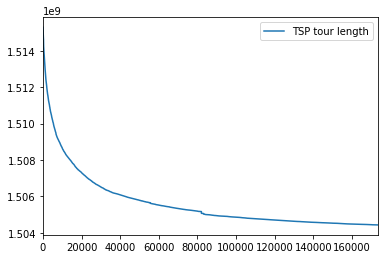

In [21]:
!sed -Ene 's/([0-9]+) Steps.*Best: ([0-9]+).*/\1,\2/p' linkern.log >linkern.csv
pd.read_csv('linkern.csv', index_col=0, names=['TSP tour length']).plot();

In [22]:
class Tour:
    cities = pd.read_csv('../data/raw/cities.csv', index_col=['CityId'])
    coords = (cities.X + 1j * cities.Y).values
    penalized = ~cities.index.isin(sympy.primerange(0, len(cities)))

    def __init__(self, data):
        """Initializes from a list/iterable of indexes or a filename of tour in csv/tsplib/linkern format."""

        if type(data) is str:
            data = self._read(data)
        elif type(data) is not np.ndarray or data.dtype != np.int32:
            data = np.array(data, dtype=np.int32)
        self.data = data

        if (self.data[0] != 0 or self.data[-1] != 0 or len(self.data) != len(self.cities) + 1):
            raise Exception('Invalid tour')

    @classmethod
    def _read(cls, filename):
        data = open(filename, 'r').read()
        if data.startswith('Path'):  # csv
            return pd.read_csv(io.StringIO(data)).Path.values
        offs = data.find('TOUR_SECTION\n')
        if offs != -1:  # TSPLIB/LKH
            data = np.fromstring(data[offs+13:], sep='\n', dtype=np.int32)
            data[-1] = 1
            return data - 1
        else:  # linkern
            data = data.replace('\n', ' ')
            data = np.fromstring(data, sep=' ', dtype=np.int32)
            if len(data) != data[0] + 1:
                raise Exception('Unrecognized format in %s' % filename)
            return np.concatenate((data[1:], [0]))

    def info(self):
        dist = np.abs(np.diff(self.coords[self.data]))
        penalty = 0.1 * np.sum(dist[9::10] * self.penalized[self.data[9:-1:10]])
        dist = np.sum(dist)
        return { 'score': dist + penalty, 'dist': dist, 'penalty': penalty }

    def dist(self):
        return self.info()['dist']

    def score(self):
        return self.info()['score']

    def __repr__(self):
        return 'Tour: %s' % str(self.info())

    def to_csv(self, filename):
        pd.DataFrame({'Path': self.data}).to_csv(filename, index=False)

In [23]:
tour = Tour('linkern.tour')
tour

Tour: {'score': 1518169.190109448, 'dist': 1504432.9664051945, 'penalty': 13736.223704253563}

In [24]:
tour.to_csv('submission.csv')

In [27]:
!gzip -kf submission.csv

In [28]:
!kaggle competitions submit -c traveling-santa-2018-prime-paths -f submission.csv.gz -m "Message"

100%|█████████████████████████████████████████| 571k/571k [00:02<00:00, 266kB/s]
Successfully submitted to Traveling Santa 2018 - Prime Paths

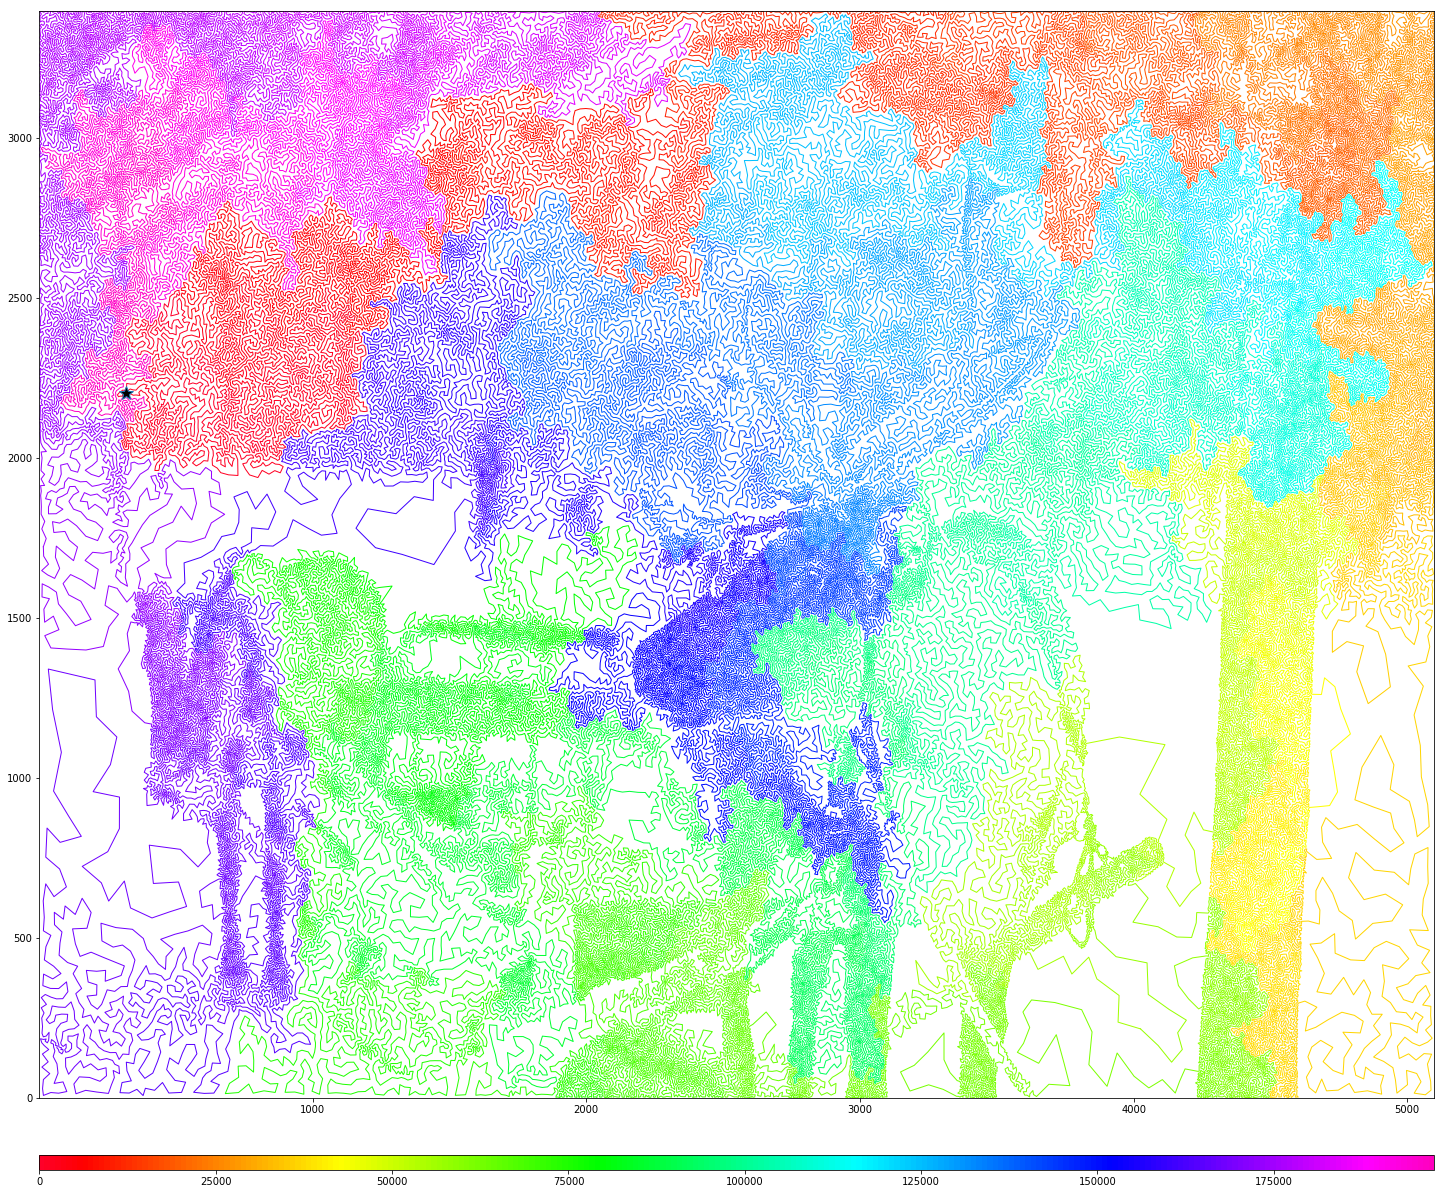

In [19]:
def plot_tour(tour, cmap=mpl.cm.gist_rainbow, figsize=(25, 20)):
    fig, ax = plt.subplots(figsize=figsize)
    n = len(tour.data)

    for i in range(201):
        ind = tour.data[n//200*i:min(n, n//200*(i+1)+1)]
        ax.plot(tour.cities.X[ind], tour.cities.Y[ind], color=cmap(i/200.0), linewidth=1)

    ax.plot(tour.cities.X[0], tour.cities.Y[0], marker='*', markersize=15, markerfacecolor='k')
    ax.autoscale(tight=True)
    mpl.colorbar.ColorbarBase(ax=fig.add_axes([0.125, 0.075, 0.775, 0.01]),
                              norm=mpl.colors.Normalize(vmin=0, vmax=n),
                              cmap=cmap, orientation='horizontal')

plot_tour(tour)